In [202]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [203]:
import numpy as np
import pandas as pd

In [204]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [205]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [206]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [207]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [208]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [209]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

Base = automap_base()
Base.prepare(engine, reflect=True)


In [210]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

A Year Ago:  2016-08-23
last_date: ('2017-08-23',)


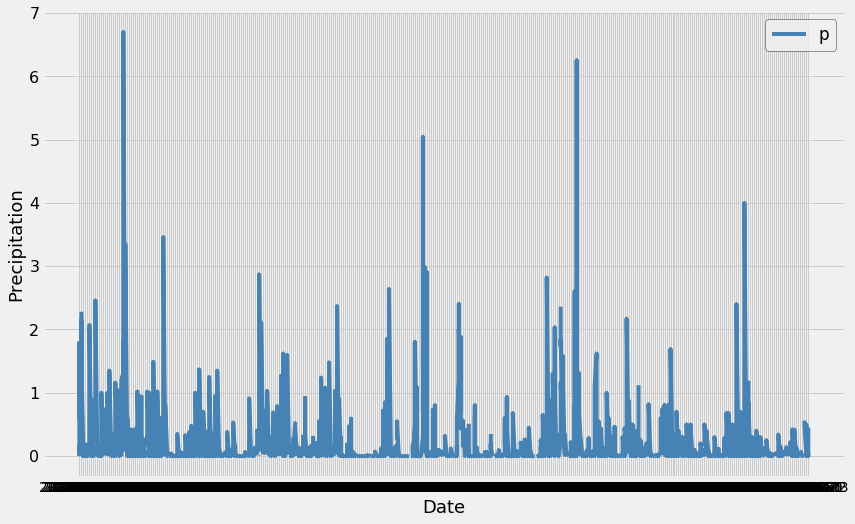

In [212]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
qry1 = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= '2016-08-23').all()
plot1_pd = pd.DataFrame(data=qry1, columns=["date", "prcp"])
plot1_pd = plot1_pd.set_index('date', drop=True)
plot1_pd

# Calculate the date 1 year ago from the last data point in the database
ayearago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("A Year Ago: ", ayearago)
# get the latest date in Measurement
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("last_date:", last_date)
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date,Measurement.prcp).\
    order_by(Measurement.date).all()
prcp
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp1 = plot1_pd['prcp']
date1 = plot1_pd.index.values


# Sort the dataframe by date
date1

# Use Pandas Plotting with Matplotlib to plot the data


plt.figure(figsize=[12.8, 8])
labels = 'precipitation'
x_axis = date1
y_axis = prcp1
plt.xlabel("Date", fontsize=18)
plt.ylabel("Precipitation", fontsize=18)
plt.tick_params(axis='y', labelsize=16)


# Plotted the chart once again as it didn't stick after being shown
plot1 = plt.plot(x_axis, y_axis, color='steelblue')
plt.legend(labels=labels, loc='upper right', fontsize='large', frameon=True, edgecolor='black')
plt.show()

![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data
plot1_pd.describe()

![describe](Images/describe.png)

In [ ]:
# Design a query to show how many stations are available in this dataset?
q2 = session.query(Station.station).count()
q2

In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
q3 = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc())
q3.all()



In [213]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = q3[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()

[(54.0, 71.66378066378067, 85.0)]

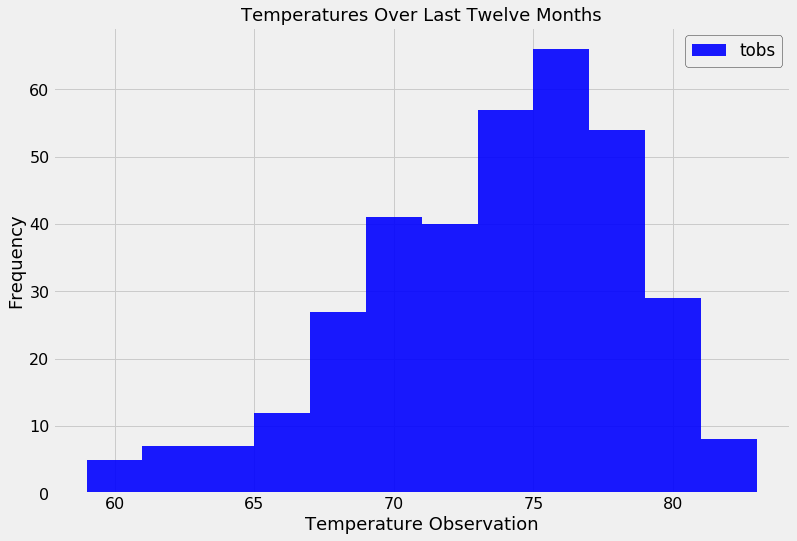

In [214]:
# Choose the station with the highest number of temperature observations.
qry3.limit(1).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
qry4 = session.query(Measurement.station, Measurement.date, Measurement.tobs).group_by(Measurement.date).\
    filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-22').\
    filter(Measurement.station=="USC00519281").all()
qry4
plot2_pd = pd.DataFrame(data=qry4, columns=["station", "date", "tobs"])
plot2_pd = plot2_pd.set_index('date', drop=True)
plot2_pd = plot2_pd.drop(columns="station", axis=1)
plot2_pd.head()

#Plotted the results as a histogram with bins=12
x = plot2_pd['tobs']
num_bins = 12
# the histogram of the data
#n, bins, patches = 
plt.figure(figsize=[12.8, 8])
temp_plot = plt.hist(x, num_bins, facecolor='blue', label='tobs', alpha=0.9)

plt.xlabel('Temperature Observation', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Temperatures Over Last Twelve Months', fontsize=18)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
legend = plt.legend(frameon=True, edgecolor='black', fontsize='large')


plt.subplots_adjust(left=0.15)
plt.show()

![precipitation](Images/station-histogram.png)

In [220]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).group_by(Measurement.date).filter(func.strftime("%Y-%m-%d", Measurement.date) >=start_date).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) <=end_date).all()
# and return the minimum, average, and maximum temperatures for that range of dates
start_date = dt.date(2012,2,28)
end_date = dt.date(2012,3,5)

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[('2012-02-28', 66.0, 70.375, 73.0), ('2012-02-29', 69.0, 72.11111111111111, 74.0), ('2012-03-01', 67.0, 71.11111111111111, 74.0), ('2012-03-02', 66.0, 69.25, 74.0), ('2012-03-03', 65.0, 69.71428571428571, 73.0), ('2012-03-04', 65.0, 68.85714285714286, 73.0), ('2012-03-05', 62.0, 65.0, 67.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Calculated the temps for my trip by running calc_temps function using matching dates from last year
data = calc_temps("2012-02-28", "2012-03-05")
plot3_pd = pd.DataFrame(data=data, columns=["date", "tmin", "tavg", "tmax"])
plot3_pd = plot3_pd.set_index('date', drop=True)
plot3_pd

<Figure size 720x432 with 0 Axes>

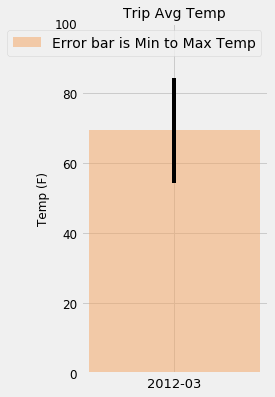

In [221]:
# Plot the results from your previous query as a bar chart. 
p3_date = plot3_pd.index.values
p3_tmin = plot3_pd['tmin']
p3_tavg = plot3_pd['tavg']
p3_tmax = plot3_pd['tmax']
plt.figure(figsize=[10, 6])
# Use "Trip Avg Temp" as your Title

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#Plotted the total Avg Temp for My Trip
plt.figure(figsize=[3, 6])


totalavg = plot3_pd['tavg'].mean()
totalavg
totalavg_plt = plt.bar('2012-03', totalavg, yerr=15, color='sandybrown', alpha=.5, label='Error bar is Min to Max Temp')
#pmax = plt.bar(p3_date, p3_tmax)

plt.ylabel('Temp (F)', fontsize=12)
plt.title('Trip Avg Temp', fontsize=14)
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(np.arange(0, 120, 20), fontsize=12)

plt.show()


In [222]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
year = dt.timedelta(days=365)
prv_start = start_date -year
prv_end = end_date - year
prcp_stn = session.query(Measurement.station, Measurement.prcp).filter(Measurement.date >= prv_start).\
                        filter(Measurement.date <= prv_end).group_by(Measurement.station).all()
prcp_stn_df = pd.DataFrame(prcp_stn, columns = ['Station', 'Precipitation Totals'])
prcp_stn_df
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

q = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= prv_start)\
.filter(Measurement.date <= prv_end)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()
print()
print (f"Historical Rainfall Per Weather Station - Descending order\n  Trip Dates: \
{trip_start} - {trip_end}\n  Most Recent Data Search Dates: {prv_start} - {prv_end}")
print()
for row in q:
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print() 


Historical Rainfall Per Weather Station - Descending order
  Trip Dates: 2012-02-28 - 2012-03-05
  Most Recent Data Search Dates: 2011-02-28 - 2011-03-06

Station:  USC00519281
    Rainfall:  0.63  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00514830
    Rainfall:  0.63  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00513117
    Rainfall:  0.63  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  0.63  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00518838
    Rainfall:  0.63  
    Location:  UPPER WAHIAWA 874.3, HI US
    Elevation:  306.6      Latitude:  21.4992  Longitude:  -158.0111

Station:  USC00516128
    Rainfall:  0.63  
    L

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
